## Installs and Imports

Install and import PyTorch along with a few helper libraries

Let's install some dependencies and clone the [TorchVision Repo](https://github.com/pytorch/vision) so we can use some helper files

In [1]:
# Install dependencies and 
# !pip install albumentations==0.4.6
# !pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
# !git clone https://github.com/pytorch/vision.git
# %cd vision
# !git checkout v0.3.0
# %cd ..
# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

Lets import the libraries

### if the git repo is downloaded then we can directly assign the system path to the detection folder to load some function which is used in import such as train_one_epoch() etc 

In [2]:
import sys
sys.path.insert(0, r"D:\work\deeplearning\detection")

In [3]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


## The Dataset 

In [5]:
from pycocotools.coco import COCO
import albumentations as A
from collections import defaultdict
# from PIL import Image, ImageDraw,ImageFont 
import torchvision.transforms as transforms
"""
CustomDataset : create class that 
and return image , target dict 

"""


class CustomDataset(torch.utils.data.Dataset):
    """
    This is class create
    """
    def __init__(self, img_dir, annot_path, transforms=False, normalize=True):
        """
        Args:
            img_dir (path): image directory path
            annot_path (json_path): coco json path
            transforms (bool): if true, albumentation transfomation is applied on image
            normalize (boll): if true , ToTensor transforation is applied on the image which convert image pixel to [0,1] and
                                        return image in form (C,H, W)
        """
        self.transforms = transforms
        self.normalize = normalize
        self.img_dir = img_dir
        self.annot_path = annot_path
        self.coco = COCO(self.annot_path)
        self.img_ids = self.coco.getImgIds()

    #         print("self.img_ids : ",self.img_ids)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        #         print("idx :",idx)
        img_id = self.img_ids[idx]
        #         print("img_id :",img_id)
        img_obj = self.coco.loadImgs(img_id)[0]
        image_name = img_obj["file_name"]
        #         print("image_name : ",image_name)
        image_path = os.path.join(self.img_dir, image_name)
        image = cv2.imread(image_path)
        img_height,img_width,_ = image.shape
#         image = cv2.resize(image,(1024,1024))
        target_height,target_width,_ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        anns_obj = self.coco.loadAnns(self.coco.getAnnIds(img_id))
        anno_data = defaultdict(list)
#         anno_data={}
        x_scale = target_width/img_width
        y_scale = target_height/img_height
        for ann in anns_obj:
            box = ann['bbox']
            xmin = box[0]
            ymin = box[1]
            xmax = box[0] + box[2]
            ymax = box[1] + box[3]
            
            xmin = int(np.round(xmin * x_scale))
            ymin = int(np.round(ymin * y_scale))
            xmax = int(np.round(xmax * x_scale))
            ymax = int(np.round(ymax * y_scale))
            
            anno_data["boxes"].append([xmin, ymin, xmax, ymax])
            #             anno_data["boxes"].append(ann['bbox'])
            anno_data['area'].append(ann['area'])
            anno_data['iscrowd'].append(ann['iscrowd'])
            anno_data['label'].append(ann['category_id'])
            anno_data["cat_name"].append(self.get_cat_names(ann['category_id']))

        # applying the albumenation transormation here for augmentation.
        if self.transforms:
            print("befor transforms : ",anno_data['boxes'])
            transformed_img, transformed_bboxes, transformed_class_labels = self.transform_img(img=image,
                                                                                               bbox=anno_data['boxes'],
                                                                                               label=anno_data["label"])
            # replcing the original image,box,label with transformed
            image = transformed_img
            anno_data['boxes'] = transformed_bboxes
            anno_data["label"] = transformed_class_labels

        if self.normalize:  # converting image to normalize (pixel value 0 to 1) tensor (C,H,W) -> float32
            transform = transforms.Compose([transforms.ToTensor()])
            image = transform(image)

        target = {
            'boxes': torch.as_tensor(anno_data['boxes'], dtype=torch.int64),
            'labels': torch.as_tensor(anno_data["label"], dtype=torch.int64),
            'image_id': torch.tensor([img_id]),  # pylint: disable=not-callable (false alarm)
            'area': torch.as_tensor(anno_data['area'], dtype=torch.float32),
            'iscrowd': torch.as_tensor(anno_data['iscrowd'], dtype=torch.int64),
#             'cat_name': anno_data["cat_name"],
        }

        return image, target

    def transform_img(self, img, bbox, label):

        """
        apply albumentation transoformation on image,bbox,label
        Args:
            self ():
            img (numpy.ndarray): image to transform
            bbox (list): bounding box list
            label (list:str): label of each bounding box

        Returns:
            tuple of transformed_image,transformed_bboxes,transformed_labels
        """

        # this is link alubumentation
        # https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/    -- for bounding box understanding
        # https://albumentations.ai/docs/ - doc file
        # https://github.com/albumentations-team/albumentations  -- list of all other transform used in Albumentation

        transform = A.Compose([
#             A.Resize (height=1024, width=1024, interpolation=1, always_apply=True, p=1),
            A.HorizontalFlip(p=1),
#             A.RandomBrightnessContrast(p=0.3),
#             A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=45, p=.3)
        ], bbox_params=A.BboxParams(format='pascal_voc', min_area=1024, min_visibility=0.3,
                                    label_fields=['class_labels']))

        transformed = transform(image=img, bboxes=bbox, class_labels=label)
        transformed_img = transformed['image']
        transformed_bboxes = transformed['bboxes']
        print("transformed_bboxes : ",transformed_bboxes)
        transformed_labels = transformed['class_labels']
        return transformed_img, transformed_bboxes, transformed_labels

    def get_cat_names(self, cat_ids=[]):
        return [data['name'] for data in self.coco.loadCats(cat_ids)][0]

## path and dataset

In [6]:
TRAIN_DIR = r"D:\UserData\z004k7nr\OneDrive - Siemens AG\neom_2\work\data\dummy_dataset\coco_fridge_data\images"
TRAIN_ANNOT_PATH =r"D:\UserData\z004k7nr\OneDrive - Siemens AG\neom_2\work\data\dummy_dataset\coco_fridge_data\train.json"
# validation images and test.json files directory/path
VALID_DIR =r"D:\UserData\z004k7nr\OneDrive - Siemens AG\neom_2\work\data\dummy_dataset\coco_fridge_data\images"
VALID_ANNOT_PATH =r"D:\UserData\z004k7nr\OneDrive - Siemens AG\neom_2\work\data\dummy_dataset\coco_fridge_data\test.json"


In [10]:
train_dataset = CustomDataset(TRAIN_DIR,TRAIN_ANNOT_PATH,transforms=True, normalize=True)
img, target = train_dataset[8]
print('Image shape:', img.shape)
print('Label example:', target)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
befor transforms :  [[0, 243, 162, 332]]
transformed_bboxes :  [(254.00000000000003, 243.0, 416.0, 332.0)]
Image shape: torch.Size([3, 416, 416])
Label example: {'boxes': tensor([[254, 243, 416, 332]]), 'labels': tensor([12]), 'image_id': tensor([8]), 'area': tensor([14418.]), 'iscrowd': tensor([0])}


# Visualization

Let's make some a helper function to view our data

In [11]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
#     img = torch.tensor(img.numpy()*255,dtype=torch.uint8)
    if isinstance(img,torch.Tensor):
        img = torchtrans.ToPILImage()(img).convert('RGB')
        
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    boxes  = target['boxes']
    if isinstance(boxes,torch.Tensor):
        boxes = boxes.cpu()
    for box in (boxes):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle(
          (x, y),
          width, height,
          linewidth = 2,
          edgecolor = 'r',
          facecolor = 'none'
        )
        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    

befor transforms :  [[26, 101, 223, 370]]
transformed_bboxes :  [(193.0, 101.0, 390.0, 370.0)]


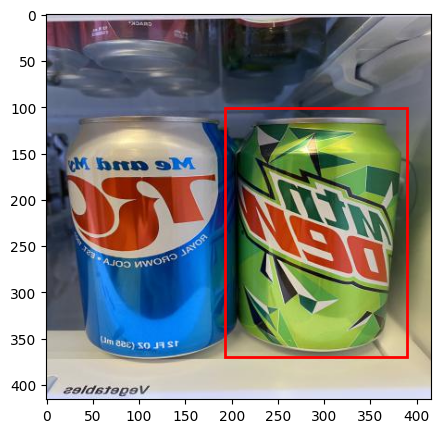

In [12]:
# plotting the image with bboxes. Feel free to change the index
img, target = train_dataset[4]
plot_img_bbox(img, target)

In [13]:
img.shape

torch.Size([3, 416, 416])

# Dataloaders

Make a loader for feeding our data into the neural network

Now lets prepare the datasets and dataloaders for training and testing.

## parameter to set

In [14]:
num_worker =0
batch_size =1
# training for 5 epochs
num_epochs = 5

In [16]:
# use our dataset and defined transformations
# dataset = ConeImagesDataset(files_dir, 480, 480, transforms=get_transform(train=True))
# dataset_test = ConeImagesDataset(files_dir, 480, 480, transforms=get_transform(train=False))

dataset =       CustomDataset(TRAIN_DIR,TRAIN_ANNOT_PATH,transforms=True, normalize=True)
dataset_test =  CustomDataset(TRAIN_DIR,VALID_ANNOT_PATH,transforms=False, normalize=True)

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=num_worker,
  collate_fn=utils.collate_fn,
#     collate_fn = collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=batch_size,
  shuffle=False,
  num_workers=num_worker,
  collate_fn=utils.collate_fn,
#   collate_fn =collate_fn
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Pre-trained Model

In [17]:
def get_object_detection_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

# Training

Let's prepare the model for training

In [18]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 14 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

Let the training begin!

In [19]:
num_epochs=5

In [20]:
print("training for epochs = ",num_epochs)

training for epochs =  5


In [21]:
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

befor transforms :  [[69, 221, 364, 332]]
transformed_bboxes :  [(52.0, 221.0, 347.0, 332.0)]
Epoch: [0]  [ 0/20]  eta: 0:00:33  lr: 0.000268  loss: 2.4052 (2.4052)  loss_classifier: 2.2257 (2.2257)  loss_box_reg: 0.1714 (0.1714)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 1.6910  data: 0.0097  max mem: 935
befor transforms :  [[21, 90, 210, 296], [203, 209, 415, 297], [324, 282, 415, 357], [85, 327, 154, 415]]
transformed_bboxes :  [(206.0, 90.0, 395.0, 296.0), (0.9999999999999964, 209.0, 213.00000000000003, 297.0), (0.9999999999999964, 282.0, 92.0, 357.0), (262.0, 327.0, 331.0, 415.0)]
befor transforms :  [[179, 93, 354, 150], [228, 169, 294, 292], [175, 209, 250, 318], [80, 352, 137, 415], [26, 354, 84, 415]]
transformed_bboxes :  [(62.000000000000014, 93.0, 237.0, 150.0), (121.99999999999999, 169.0, 187.99999999999997, 292.0), (166.0, 209.0, 241.00000000000003, 318.0), (279.0, 352.0, 336.0, 415.0), (332.0, 354.0, 390.0, 415.0)]
befor transforms :  [[

befor transforms :  [[84, 168, 146, 290], [213, 204, 288, 294], [4, 0, 132, 146]]
transformed_bboxes :  [(270.0, 168.0, 332.0, 290.0), (128.0, 204.0, 203.00000000000003, 294.0), (284.0, 0.0, 412.0, 146.0)]
Epoch: [0]  [19/20]  eta: 0:00:00  lr: 0.005000  loss: 1.9540 (1.7164)  loss_classifier: 1.0282 (1.1443)  loss_box_reg: 0.4789 (0.5330)  loss_objectness: 0.0173 (0.0243)  loss_rpn_box_reg: 0.0079 (0.0148)  time: 0.4695  data: 0.0075  max mem: 1201
Epoch: [0] Total time: 0:00:09 (0.4697 s / it)
creating index...
index created!


IndexError: list index out of range

In [ ]:
filepath = r"D:\work\trackout\training_data\model\model_"+str(num_epochs)+".pth"
state = {
    'epoch': num_epochs,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

torch.save(state, filepath)

In [ ]:
t_state = torch.load(filepath)


In [ ]:
t_state.keys()

In [ ]:
m= model.load_state_dict(t_state['state_dict'])
opt =optimizer.load_state_dict(t_state['optimizer'])
n_e = t_state["epoch"]

In [ ]:
n_e

In [ ]:
opt

In [ ]:
m

# Filtering the outputs

Our model predicts a lot of bounding boxes per image, so take out the overlapping ones, we will use **Non Max Suppression** (NMS). If you want to brush up on that, check [this](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) out.

Torchvision provides us a utility to apply NMS to our predictions, lets build a function `apply_nms` using that.

In [ ]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our Model

Now lets take an image from the test set and try to predict on it

In [ ]:
# test_dataset = ConeImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))

# pick one image from the test set
img, target = dataset_test[2]
# i =img
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print("type of prediction : ",type(prediction))
print("prediction : ",prediction)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

In [ ]:
img =torch_to_pil(img.cuda().cpu())


# plot_img_bbox(torch_to_pil(img), nms_prediction)
plot_img_bbox(img, nms_prediction)

# rough

In [ ]:
# xml_path  =r"C:\Users\z004k7nr\Desktop\test.xml"
# xml_path =r"D:\work\trackout\data\annot\DJI_20211123144939_0008_W.xml"
# xml_path =r"D:\work\trackout\data\annot\DJI_20211123144956_0012_W.xml"

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse(xml_path)
root = tree.getroot()

In [ ]:
root.text

In [ ]:
get_elements(root, 'object')

In [ ]:
for obj in get_elements(root, 'object'):


    # annotation: id
#     bbox_id += 1

    # annotation: bbox
    bndbox = get_element(obj, 'bndbox')
#             print("len of bndbox : ",bndbox)
    xmin = int(get_element(bndbox, 'xmin').text)
    ymin = int(get_element(bndbox, 'ymin').text)
    xmax = int(get_element(bndbox, 'xmax').text)
    ymax = int(get_element(bndbox, 'ymax').text)
    
    print("[xmin, ymin, bbox_width, bbox_height] : ",xmin, ymin, xmax, ymax)

In [ ]:
def get_elements(root, childElementName):
    elements = root.findall(childElementName)
    return elements
def get_element(root, childElementName):
    element = root.find(childElementName)
    return element